In [34]:
import pandas as pd
import numpy as np
import os

def find_drought_onsets(df, spi_threshold=-1.0):
    """Identifies drought onset indices directly from DataFrame."""
    df = df.sort_values("Date").reset_index(drop=True)
    df["is_drought"] = df["SPI"] < spi_threshold
    df["prev_is_drought"] = df["is_drought"].shift(1).fillna(False)
    df["drought_onset"] = df["is_drought"] & (~df["prev_is_drought"])
    drought_onset_indices = df[df["drought_onset"]].index.tolist()
    print(f"Found {len(drought_onset_indices)} drought onset periods.")
    return drought_onset_indices

def calculate_baselines(df, drought_indices, time_windows=[1, 2, 3]):
    """Calculates pre-drought NDVI and adjusted NDVI baselines including VPD values."""
    results = []
    min_vpd_threshold = 1e-6

    for onset_index in drought_indices:
        drought_date = df.loc[onset_index, "Date"]
        baseline_data = {"Drought_Onset_Date": drought_date}
        valid_windows = {}

        for window in time_windows:
            start_index = onset_index - window
            end_index = onset_index
            if start_index < 0:
                for key in ["NDVI", "VPD", "Adj_NDVI"]:
                    baseline_data[f"{key}_Baseline_{window}m"] = np.nan
                continue

            period = df.iloc[start_index:end_index]
            if period["NDVI"].isnull().any() or period["VPD"].isnull().any():
                for key in ["NDVI", "VPD", "Adj_NDVI"]:
                    baseline_data[f"{key}_Baseline_{window}m"] = np.nan
                continue

            mean_ndvi = period["NDVI"].mean()
            mean_vpd = period["VPD"].mean()
            adj_ndvi = np.nan if mean_vpd < min_vpd_threshold else mean_ndvi / mean_vpd

            baseline_data[f"NDVI_Baseline_{window}m"] = mean_ndvi
            baseline_data[f"VPD_Baseline_{window}m"] = mean_vpd
            baseline_data[f"Adj_NDVI_Baseline_{window}m"] = adj_ndvi
            valid_windows[window] = adj_ndvi

        if valid_windows:
            optimal_window = max(valid_windows, key=valid_windows.get)
            baseline_data["Optimal_Window_Months"] = optimal_window
            baseline_data["Optimal_Adj_NDVI"] = valid_windows[optimal_window]
            baseline_data["Optimal_NDVI_Baseline"] = baseline_data[f"NDVI_Baseline_{optimal_window}m"]
            baseline_data["Optimal_VPD_Baseline"] = baseline_data[f"VPD_Baseline_{optimal_window}m"]
        else:
            baseline_data.update({
                "Optimal_Window_Months": np.nan,
                "Optimal_Adj_NDVI": np.nan,
                "Optimal_NDVI_Baseline": np.nan,
                "Optimal_VPD_Baseline": np.nan,
            })

        results.append(baseline_data)

    return pd.DataFrame(results)

def calculate_summary_statistics(df, baseline_df, output_dir="/content", base_filename="summary"):
    """Calculates and saves regional summary statistics including total NDVI/VPD."""
    numeric_df = baseline_df.select_dtypes(include='number')
    summary = {
        "Mean_Optimal_NDVI_Baseline": baseline_df["Optimal_NDVI_Baseline"].dropna().mean(),
        "Median_Optimal_NDVI_Baseline": baseline_df["Optimal_NDVI_Baseline"].dropna().median(),
        "Mean_Optimal_VPD_Baseline": baseline_df["Optimal_VPD_Baseline"].dropna().mean(),
    }

    for col in numeric_df.columns:
        summary[f"Mean_{col}"] = numeric_df[col].mean()

    # Add overall mean NDVI and VPD for full CSV
    summary["Overall_Mean_NDVI"] = df["NDVI"].dropna().mean()
    summary["Overall_Mean_VPD"] = df["VPD"].dropna().mean()

    summary_df = pd.DataFrame([summary])
    output_path = os.path.join(output_dir, f"{base_filename}_statistics.csv")
    summary_df.to_csv(output_path, index=False)
    print(f"Summary statistics saved to {output_path}")
    return summary_df

def process_drought_analysis(csv_filepath, output_dir="/content"):
    """Master function to run full drought analysis pipeline."""
    try:
        df = pd.read_csv(csv_filepath)
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    required_cols = ["Date", "SPI", "NDVI", "VPD"]
    if not all(col in df.columns for col in required_cols):
        print(f"Missing columns. Required: {required_cols}")
        return

    drought_indices = find_drought_onsets(df)
    if not drought_indices:
        print("No drought onsets found. Exiting.")
        return

    baseline_df = calculate_baselines(df, drought_indices)
    base_filename = os.path.splitext(os.path.basename(csv_filepath))[0]
    baseline_path = os.path.join(output_dir, f"{base_filename}_baseline_results.csv")
    baseline_df.to_csv(baseline_path, index=False, date_format="%Y-%m-%d")
    print(f"Baseline results saved to {baseline_path}")

    calculate_summary_statistics(df, baseline_df, output_dir=output_dir, base_filename=base_filename)

# --- Main execution ---
process_drought_analysis(r"Data\Merged SPI & NDVI & VPD\Region wise CSV\Wet Tropics.csv", output_dir=r"Results\NDVI Baseline\Region Wise\Baseline Results")


Found 30 drought onset periods.
Baseline results saved to Results\NDVI Baseline\Region Wise\Baseline Results\Wet Tropics_baseline_results.csv
Summary statistics saved to Results\NDVI Baseline\Region Wise\Baseline Results\Wet Tropics_statistics.csv


C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\1047437253.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_is_drought"] = df["is_drought"].shift(1).fillna(False)


In [38]:
import glob as glob

# Define the directory containing the NDVI statistics files
statistics_dir = r"Results\NDVI Baseline\Region Wise"

# Use glob to find all CSV files in the directory
statistics_files = glob.glob(f"{statistics_dir}/*_statistics.csv")

# Combine all the files into a single DataFrame
combined_df = pd.concat([pd.read_csv(file) for file in statistics_files], ignore_index=True)

# Save the combined DataFrame to a single CSV file
output_path = r"Results\NDVI Baseline\All Region Comparison\Combined_NDVI_Statistics.csv"
combined_df.to_csv(output_path, index=False)

print(f"Combined NDVI statistics saved to {output_path}")

Combined NDVI statistics saved to Results\NDVI Baseline\All Region Comparison\Combined_NDVI_Statistics.csv


In [39]:
# Extract region names from file paths and add as a new column
region_names = [os.path.basename(file).replace("_statistics.csv", "").replace("_", " ") for file in statistics_files]
combined_df["Region"] = region_names

# Save the updated DataFrame to a single CSV file
output_path = r"Results\NDVI Baseline\All Region Comparison\Combined_NDVI_Statistics.csv"
combined_df.to_csv(output_path, index=False)

print(f"Combined NDVI statistics with region names saved to {output_path}")

Combined NDVI statistics with region names saved to Results\NDVI Baseline\All Region Comparison\Combined_NDVI_Statistics.csv


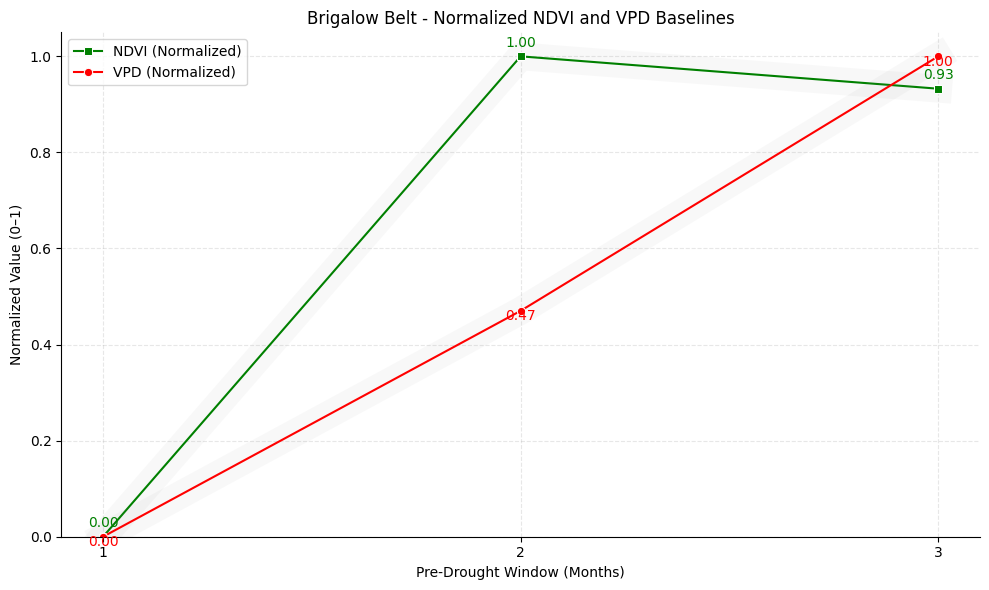

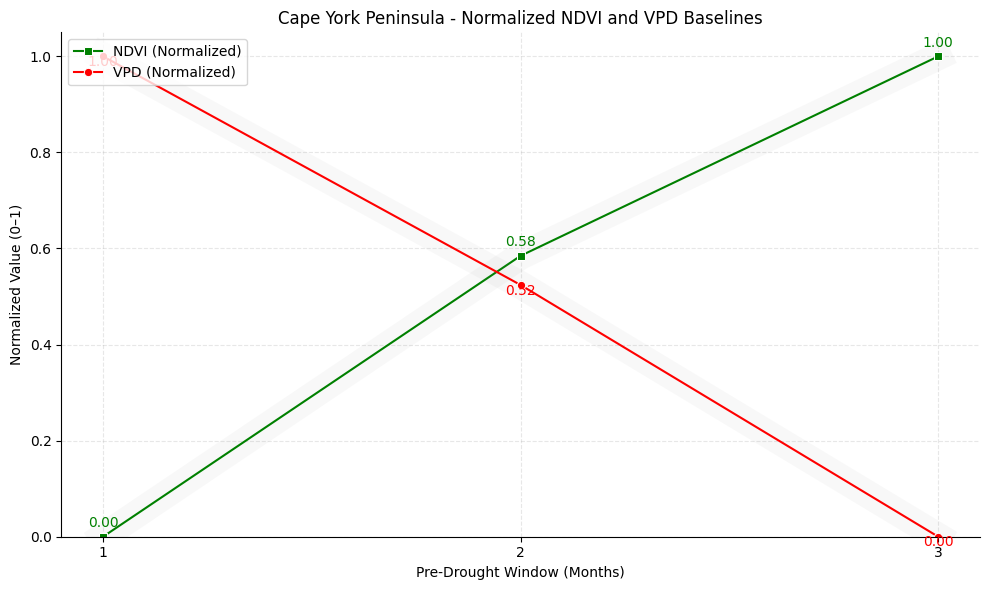

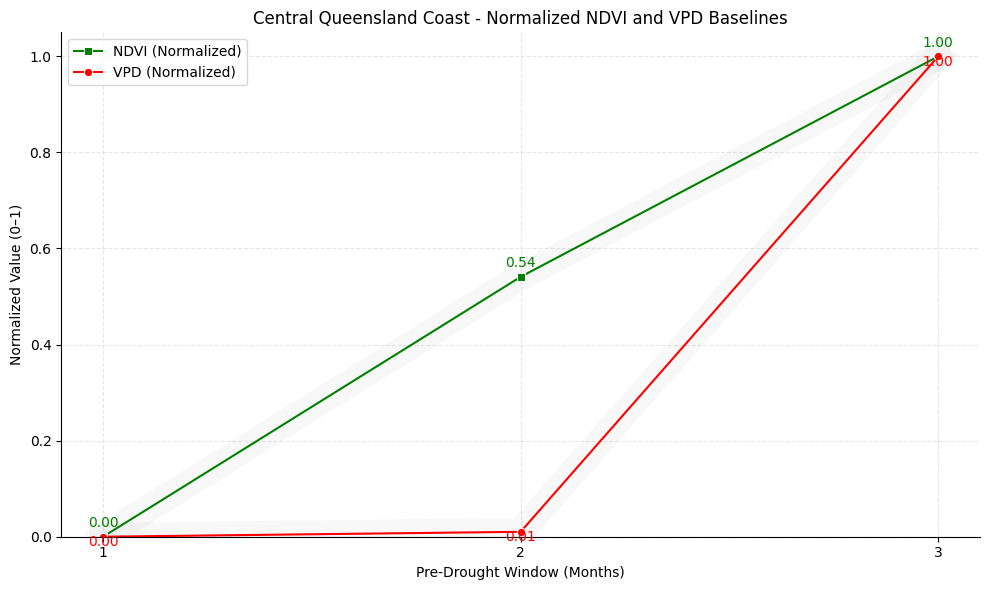

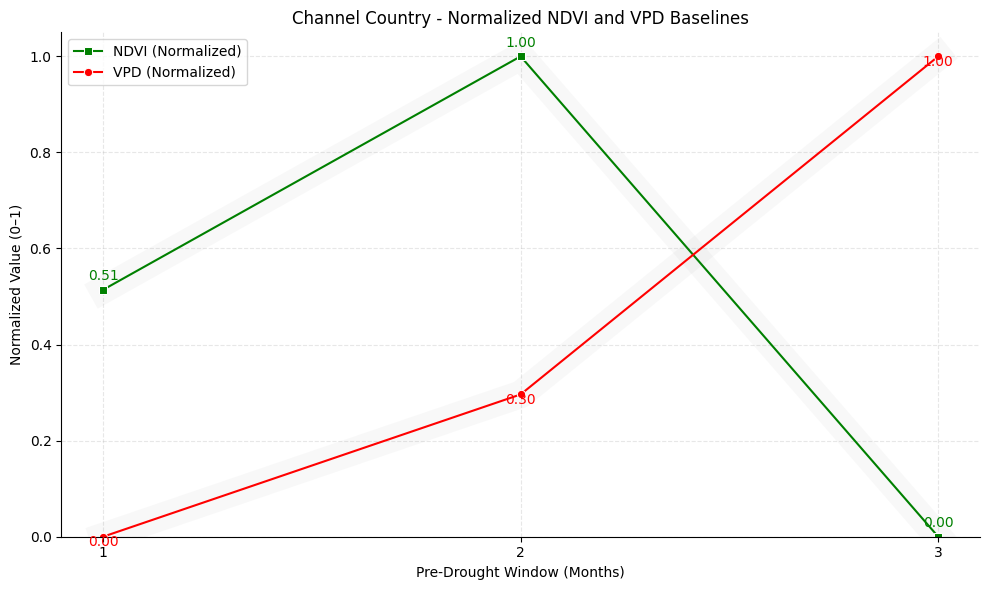

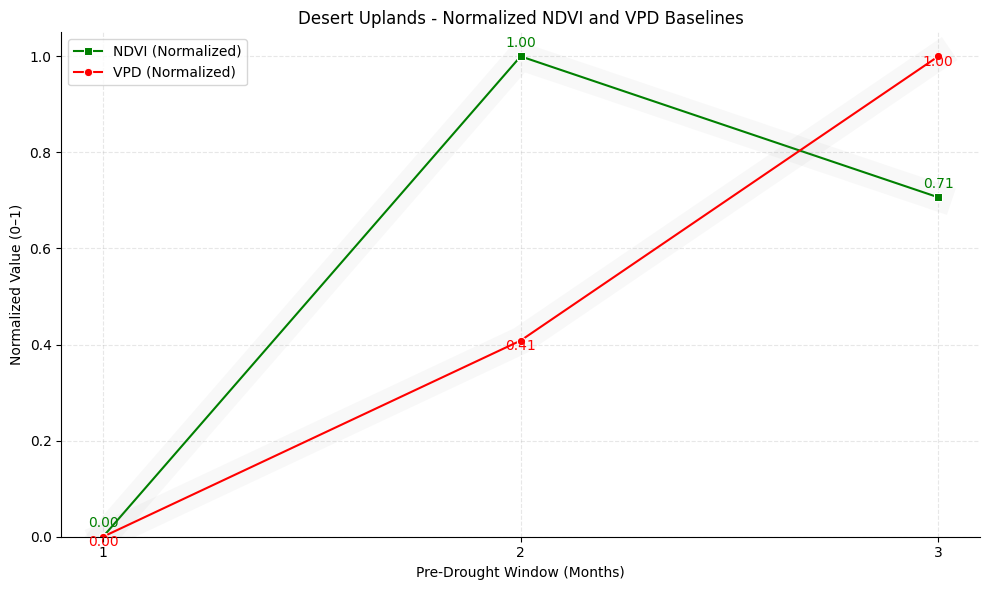

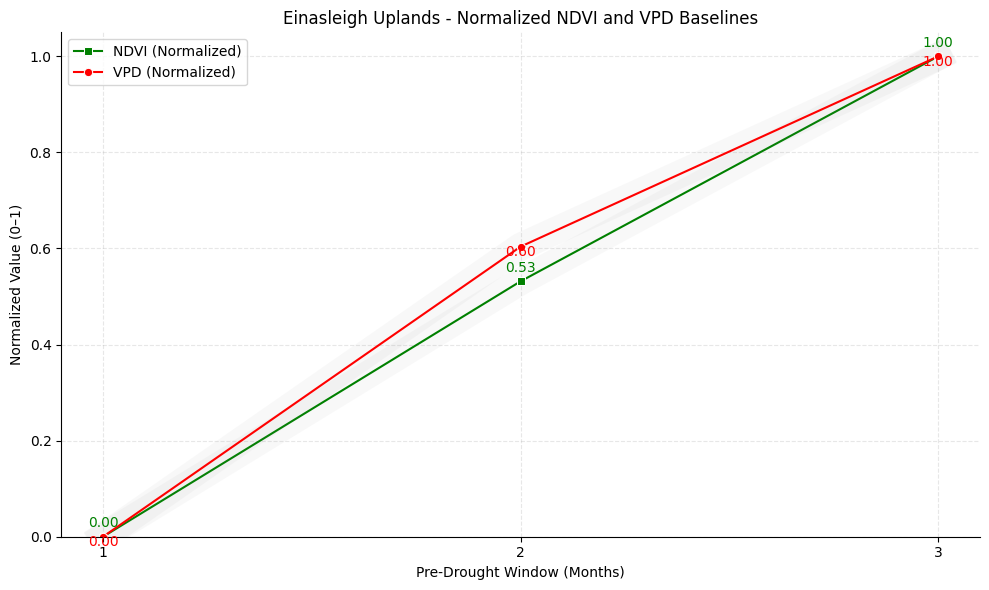

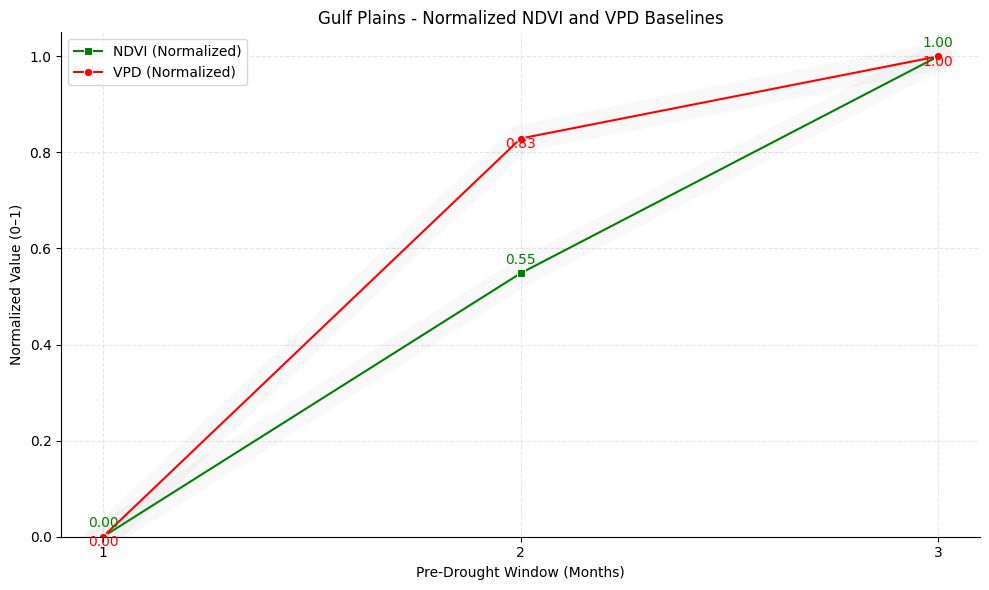

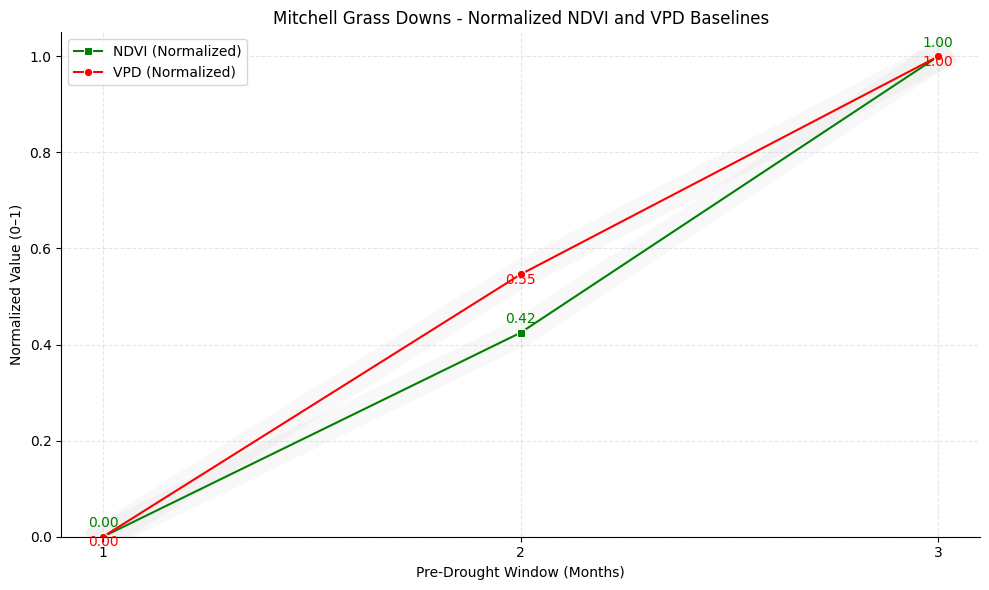

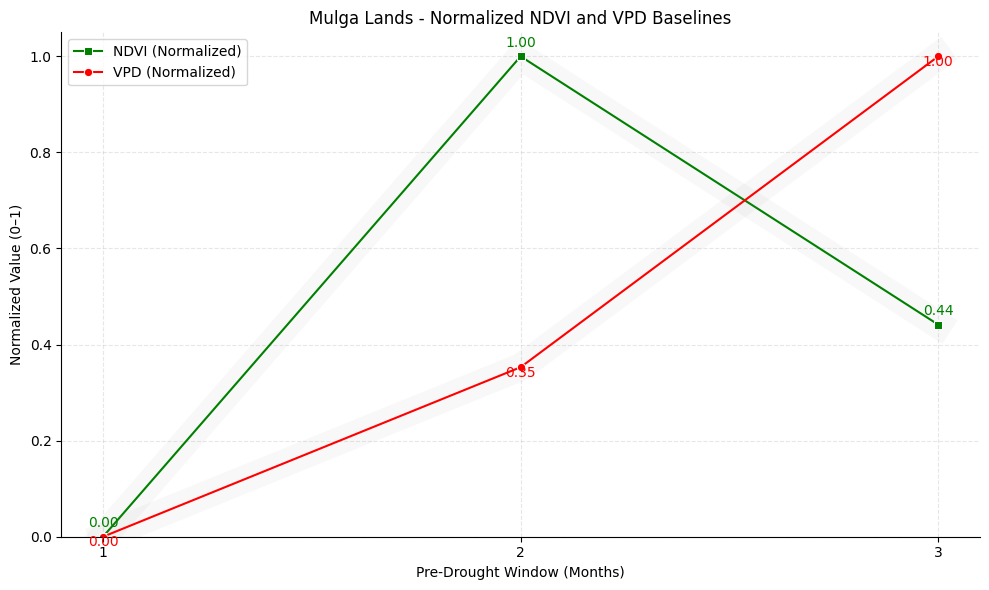

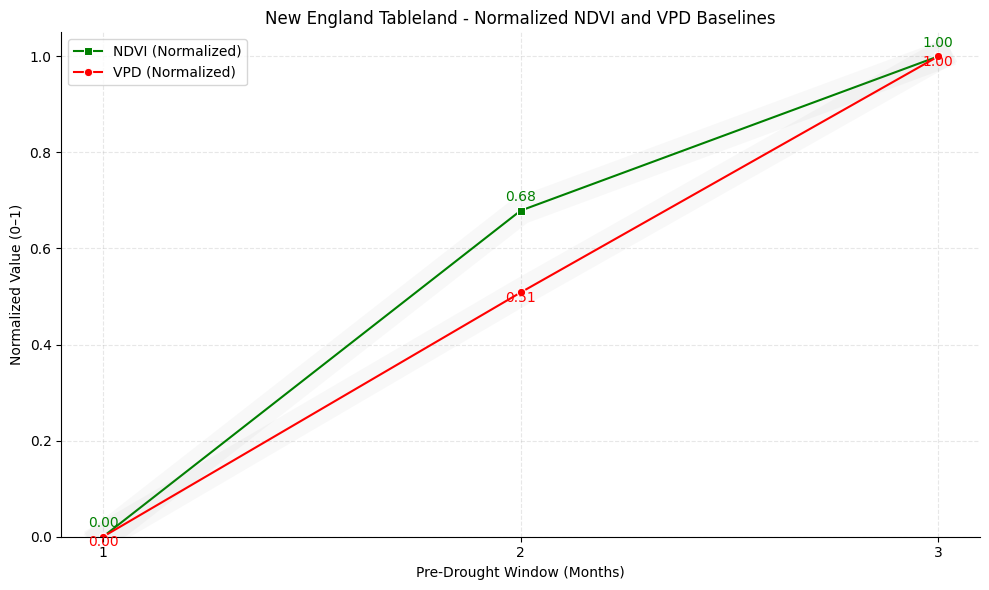

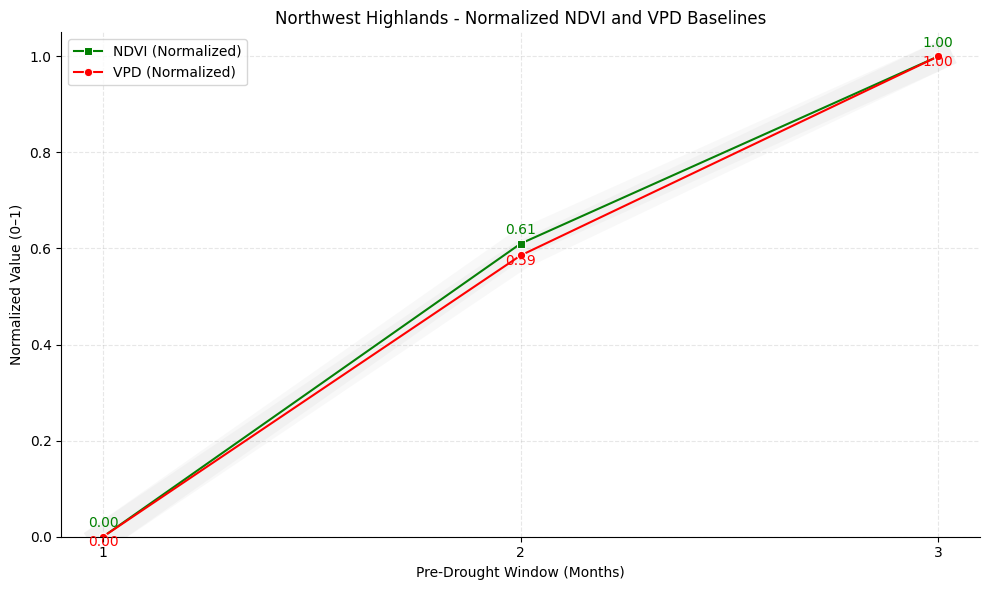

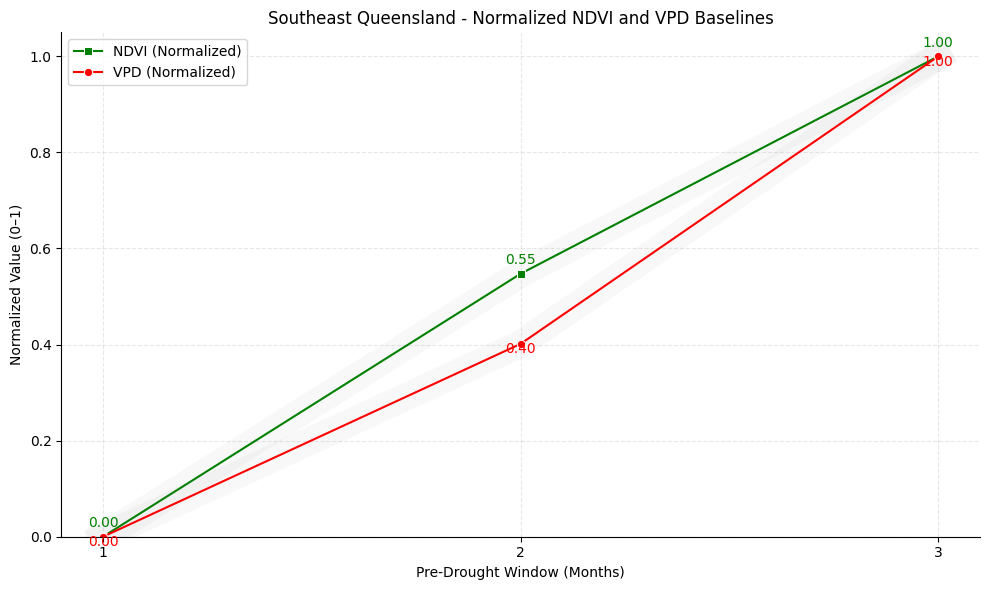

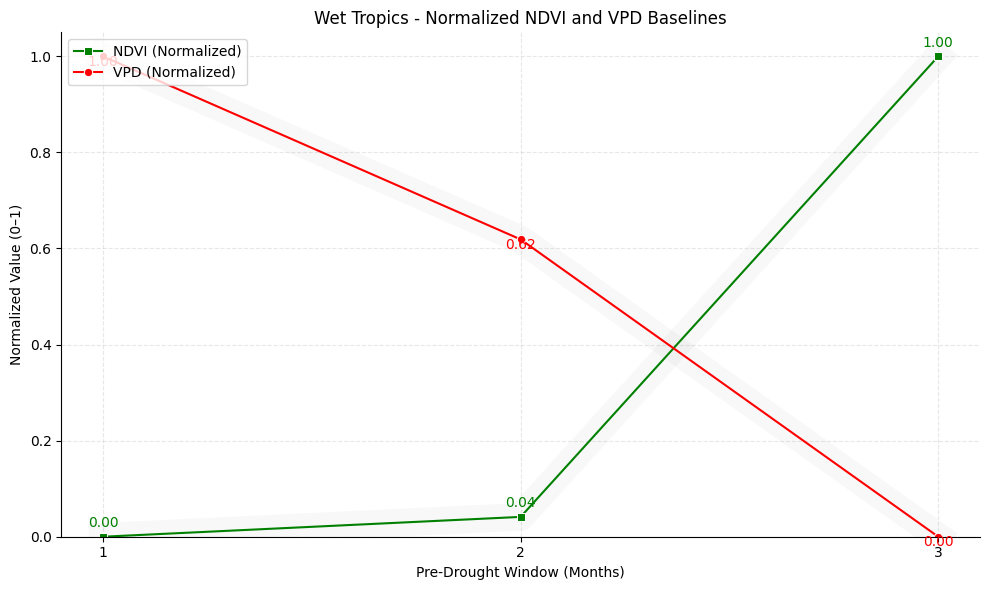

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_normalized_summary(summary_csv_path):
    df = pd.read_csv(summary_csv_path)

    for _, row in df.iterrows():
        region = row["Region"]
        thresholds = [1, 2, 3]

        ndvi_vals = [
            row["Mean_NDVI_Baseline_1m"],
            row["Mean_NDVI_Baseline_2m"],
            row["Mean_NDVI_Baseline_3m"]
        ]
        vpd_vals = [
            row["Mean_VPD_Baseline_1m"],
            row["Mean_VPD_Baseline_2m"],
            row["Mean_VPD_Baseline_3m"]
        ]

        # Normalize both NDVI and VPD
        def normalize(lst):
            min_val, max_val = min(lst), max(lst)
            return [(x - min_val) / (max_val - min_val) if max_val != min_val else 0.5 for x in lst]

        ndvi_norm = normalize(ndvi_vals)
        vpd_norm = normalize(vpd_vals)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Glow line for NDVI
        sns.lineplot(x=thresholds, y=ndvi_norm, ax=ax,
                     color='grey', linewidth=20, alpha=0.05)

        # NDVI normalized line
        sns.lineplot(x=thresholds, y=ndvi_norm, ax=ax,
                     color='green', marker='s', label='NDVI (Normalized)')
        for x, y in zip(thresholds, ndvi_norm):
            ax.text(x, y + 0.02, f'{y:.2f}', color='green', ha='center')

        # Glow line for VPD
        sns.lineplot(x=thresholds, y=vpd_norm, ax=ax,
                     color='grey', linewidth=20, alpha=0.05)

        # VPD normalized line
        sns.lineplot(x=thresholds, y=vpd_norm, ax=ax,
                     color='red', marker='o', label='VPD (Normalized)')
        for x, y in zip(thresholds, vpd_norm):
            ax.text(x, y - 0.02, f'{y:.2f}', color='red', ha='center')

        ax.set_xlabel('Pre-Drought Window (Months)')
        ax.set_ylabel('Normalized Value (0–1)')
        ax.set_xticks([1, 2, 3])
        ax.set_ylim(0, 1.05)
        ax.grid(True, which='major', linestyle='--', alpha=0.3)
        ax.set_title(f'{region} - Normalized NDVI and VPD Baselines')

        # Remove unnecessary borders
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

# Example usage:
plot_normalized_summary(r"Results\NDVI Baseline\All Region Comparison\Combined_NDVI_Statistics.csv")


In [60]:
import pandas as pd
import numpy as np
import os

def process_region_summary(csv_path, windows=[1, 2, 3], max_lag=6):
    df = pd.read_csv(csv_path)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df = df.sort_values("Date").reset_index(drop=True)

    # Identify drought onsets
    df["is_drought"] = df["SPI"] < -1.0
    df["prev_drought"] = df["is_drought"].shift(1).fillna(False)
    df["onset"] = df["is_drought"] & (~df["prev_drought"])
    onset_indices = df[df["onset"]].index.tolist()

    # Store all per-window stats
    ndvi_all = {w: [] for w in windows}
    vpd_all = {w: [] for w in windows}
    adj_all = {w: [] for w in windows}

    for idx in onset_indices:
        for w in windows:
            start = idx - w
            if start < 0:
                continue
            ndvi_vals = df["NDVI"].iloc[start:idx]
            vpd_vals = df["VPD"].iloc[start:idx]

            if ndvi_vals.isnull().any() or vpd_vals.isnull().any():
                continue

            ndvi_mean = ndvi_vals.mean()
            vpd_mean = vpd_vals.mean()
            if vpd_mean < 1e-6:
                continue

            ndvi_all[w].append(ndvi_mean)
            vpd_all[w].append(vpd_mean)
            adj_all[w].append(ndvi_mean / vpd_mean)

    # Compute true mean values for each window
    means = {}
    for w in windows:
        means[w] = {
            f"Mean_NDVI_Baseline_{w}m": np.mean(ndvi_all[w]) if ndvi_all[w] else np.nan,
            f"Mean_VPD_Baseline_{w}m": np.mean(vpd_all[w]) if vpd_all[w] else np.nan,
            f"Mean_Adj_NDVI_Baseline_{w}m": np.mean(adj_all[w]) if adj_all[w] else np.nan
        }

    # Select optimal window based on actual mean of Adjusted NDVI
    best_window = max(windows, key=lambda w: means[w][f"Mean_Adj_NDVI_Baseline_{w}m"] if not np.isnan(means[w][f"Mean_Adj_NDVI_Baseline_{w}m"]) else -np.inf)
    optimal_ndvi = means[best_window][f"Mean_NDVI_Baseline_{best_window}m"]

    # Calculate recovery lags based on optimal NDVI
    recovery_lags = []
    for idx in onset_indices:
        for lag in range(1, max_lag+1):
            check = idx + lag
            if check >= len(df):
                break
            if df.loc[check, "SPI"] >= -0.5 and df.loc[check, "NDVI"] >= optimal_ndvi:
                recovery_lags.append(lag)
                break

    mean_recovery_lag = np.mean(recovery_lags) if recovery_lags else np.nan

    # Final result dictionary
    result = {
        "Region": os.path.basename(csv_path).replace(".csv", ""),
        "Mean_Optimal_Window_Months": best_window,
        "Mean_Optimal_NDVI_Baseline": optimal_ndvi,
        "Mean_Optimal_VPD_Baseline": means[best_window][f"Mean_VPD_Baseline_{best_window}m"],
        "Mean_Optimal_Adj_NDVI": means[best_window][f"Mean_Adj_NDVI_Baseline_{best_window}m"],
        "Mean_Recovery_Lag": mean_recovery_lag
    }

    for w in windows:
        result.update(means[w])

    return result


In [61]:
import glob

csv_files = glob.glob(r"Data\Merged SPI & NDVI & VPD\Region wise CSV\*.csv")
all_summaries = [process_region_summary(f) for f in csv_files]
summary_df = pd.DataFrame(all_summaries)
summary_df.to_csv(r"Results\NDVI Baseline\All in one - Recovery Lag\final_regional_summary.csv", index=False)
print(summary_df)


C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\773378440.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_drought"] = df["is_drought"].shift(1).fillna(False)
C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\773378440.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_drought"] = df["is_drought"].shift(1).fillna(False)
C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\773378440.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_ob

                      Region  Mean_Optimal_Window_Months  \
0              Brigalow Belt                           1   
1        Cape York Peninsula                           3   
2   Central Queensland Coast                           1   
3            Channel Country                           1   
4             Desert Uplands                           1   
5         Einasleigh Uplands                           1   
6                Gulf Plains                           3   
7       Mitchell Grass Downs                           1   
8                Mulga Lands                           1   
9      New England Tableland                           1   
10       Northwest Highlands                           1   
11      Southeast Queensland                           1   
12               Wet Tropics                           3   

    Mean_Optimal_NDVI_Baseline  Mean_Optimal_VPD_Baseline  \
0                     0.440931                  13.134059   
1                     0.579191       

C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\773378440.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_drought"] = df["is_drought"].shift(1).fillna(False)
C:\Users\Jspch\AppData\Local\Temp\ipykernel_13120\773378440.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_drought"] = df["is_drought"].shift(1).fillna(False)


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_scatter_with_regression(csv_path, output_dir=r"Data\Merged SPI & NDVI & VPD\Region wise CSV\Plots\Plot_v03"):
    region_name = os.path.basename(csv_path).replace(".csv", "")
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Only use valid rows
    df = df.dropna(subset=["SPI", "NDVI", "VPD"])

    # Label SPI < -1 as drought
    df["Drought"] = df["SPI"] < -1.0

    plot_pairs = [
        ("SPI", "NDVI"),
        ("SPI", "VPD"),
        ("NDVI", "VPD")
    ]

    for x, y in plot_pairs:
        plt.figure(figsize=(8, 6))

        # Scatterplot by drought condition
        sns.scatterplot(data=df, x=x, y=y, hue="Drought", palette={True: "red", False: "steelblue"}, alpha=0.6, edgecolor="k", linewidth=0.3)

        # Linear regression on all points
        sns.regplot(x=x, y=y, data=df, scatter=False, color="black", label="Linear fit")

        # LOWESS (non-parametric) on all points
        lowess_smoothed = lowess(df[y], df[x], frac=0.5)
        plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="green", linestyle="--", label="LOWESS")

        # Final formatting
        plt.title(f"{region_name}: {y} vs {x}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.grid(True)
        plt.legend(title="SPI < -1.0")
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"{region_name}_{y}_vs_{x}_highlighted.png")
        plt.savefig(save_path)
        plt.close()
        print(f"Saved: {save_path}")


In [35]:
import glob

region_files = glob.glob(r"Data\Merged SPI & NDVI & VPD\Cape_York_Peninsula_merged_spi_ndvi.csv")  # Use your actual path
for file in region_files:
    plot_scatter_with_regression(file)


Saved: Data\Merged SPI & NDVI & VPD\Region wise CSV\Plots\Plot_v03\Cape_York_Peninsula_merged_spi_ndvi_NDVI_vs_SPI_highlighted.png
Saved: Data\Merged SPI & NDVI & VPD\Region wise CSV\Plots\Plot_v03\Cape_York_Peninsula_merged_spi_ndvi_VPD_vs_SPI_highlighted.png
Saved: Data\Merged SPI & NDVI & VPD\Region wise CSV\Plots\Plot_v03\Cape_York_Peninsula_merged_spi_ndvi_VPD_vs_NDVI_highlighted.png


In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_baseline_scatter(csv_path, save_dir=r"Results\NDVI Baseline\Region Wise\Plots"):
    df = pd.read_csv(csv_path)
    region = os.path.basename(csv_path).replace(".csv", "")

    # Make long format
    records = []
    for i, row in df.iterrows():
        for w in [1, 2, 3]:
            records.append({
                "SPI_Onset": -1.0,  # all events are SPI < -1.0
                "NDVI_Baseline": row[f"NDVI_Baseline_{w}m"],
                "VPD_Baseline": row[f"VPD_Baseline_{w}m"],
                "Window": f"{w}m"
            })
    long_df = pd.DataFrame(records).dropna()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot 3: VPD vs NDVI
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=long_df, x="NDVI_Baseline", y="VPD_Baseline", hue="Window", palette="Set2")
    plt.title(f"{region}: VPD vs NDVI Baseline")
    plt.xlabel("NDVI Baseline")
    plt.ylabel("VPD Baseline")
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{region}_VPD_vs_NDVI.png")
    plt.close()

    print(f"Saved 3 plots for {region} to '{save_dir}'")


In [70]:
import glob

files = glob.glob(r"Results\NDVI Baseline\Region Wise\Brigalow Belt_baseline_results.csv")  # Adjust path
for f in files:
    plot_baseline_scatter(f)


Saved 3 plots for Brigalow Belt_baseline_results to 'Results\NDVI Baseline\Region Wise\Plots'
